Jesus is a Rasin

In [1]:
import cupy
from cupy import fft
import tiffile
import math
import numpy as np
import ComputeGaussianPSF as CG

import matplotlib.pyplot as plt

from pypher.pypher import (parse_args, format_kernel_header,
                           imrotate, imresample, trim, zero_pad,
                           psf2otf, homogenization_kernel)
import RL_TV


Loading all the Shazbot

In [2]:
stack_filename = r'G:\My Drive\MATLAB\Extended-Volume-3D-deconvolution-master\Extended-Volume-3D-deconvolution-master\code\aligned_vol_crop2.tif'
stack = tiffile.imread(stack_filename)

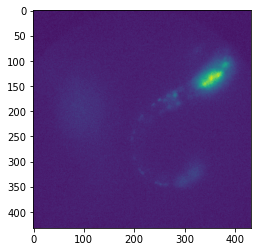

In [3]:
plt.imshow(stack[273,13,:,: ])                                                                                                                                                                                                                                                                                                                                                                                             

In [4]:

# matlab code
# [XX,YY,ZZ,TT] = size(stack); <--- needs to be [TT,ZZ,YY,XX]

dims = stack.shape
XX = dims[3]
YY = dims[2]
ZZ = dims[1]
TT = dims[0]

# %imaging parameters (Original)
# % NA = 0.4; % objective numerical aperture
# % dz = 20.56; % delta z, um
# % dx = 1.083; % laterial pixel size, um
# % lambda = 0.51; % wavelength, um
# % index = 1.0; % refractive index

# %OURS M25
# % imaging parameters
NumAp = 1.4 # objective numerical aperture
dz = 2.0 # % delta z, um
dx = 0.8895 # % laterial pixel size, um
waveLength = 0.515 # % wavelength, um
index = 1.51 # % refractive index

# optimization parameters
TV_reg = 0 # amount of TV regularization
xy_pad = 50 # lateral volume extension
z_pad = 8 # axial volume extension
# Original settings
# outer_iter = 20 # number of outer iterations of EV-3D
# inner_iter = 80 # number of inner iterations of EV-3D

# rl_iter = 200 # number of iteratins for traditional RL-3D
outer_iter = 20 # number of outer iterations of EV-3D
inner_iter = 80 # number of inner iterations of EV-3D

rl_iter = 200 # number of iteratins for traditional RL-3D

The thing it does

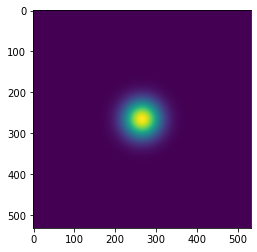

In [5]:
## EV-3D deconvolution
Nx = XX + 2*xy_pad
Ny = YY + 2*xy_pad ## image should be square so XX == YY
Nz = ZZ + 2*z_pad

# psf = ComputeGaussianPSF(NA,lambda,dx,dz,Nx,floor(Nz/2),index);
psf = CG.ComputeGaussianPSF(NumAp,waveLength,dx,dz,Nx,math.floor(Nz/2),index);
otf = psf2otf(psf, psf.shape);
otf = np.reshape(otf, (otf.size,), order='C')

plt.imshow(psf[0,:,:])
#plt.imshow(np.abs(otf[0,:,:]))

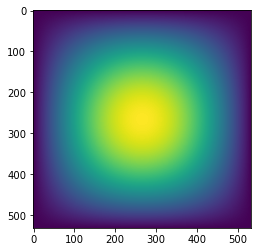

In [6]:
plt.imshow(np.abs(np.fft.fftshift(np.reshape(otf, (psf.shape), order='C')[0,:,:])))

In [7]:
#im_ev = padarray(stack, [xy_pad, xy_pad, z_pad], 'replicate', 'both'); % image over V_EV
#im_mask = padarray(stack, [xy_pad, xy_pad, z_pad], 0, 'both');
#im_mask = find(im_mask>0); % pixel indices of V_I
#obs = stack(stack>0); % corresponding pixel values of V_I
im_ev = np.pad(stack[300,:,:,:], ((z_pad,),(xy_pad,), (xy_pad,)), 'edge' )
im_ev = np.reshape(im_ev, (im_ev.size,), order='C')
im_mask = np.pad(stack[300,:,:,:], ((z_pad,), (xy_pad,), (xy_pad,)), 'constant', constant_values=(0,) )
print(im_mask.shape)
im_mask = np.ravel_multi_index(np.where(im_mask>0),im_mask.shape)
#im_mask = np.where(im_mask>0); # pixel indices of V_I
temp = stack[300,:,:,:]
obs = temp[np.where(temp != 0)] # corresponding pixel values of V_I
#print(im_mask)
print(obs.size)
print(stack[300,0,0,0])

(41, 532, 532)
4665600
848


0
0
0
7564492800
(4665600,)
(11603984,)
(11603984,)
(4665600,)
32539168
232
7308771328
(11603984,)


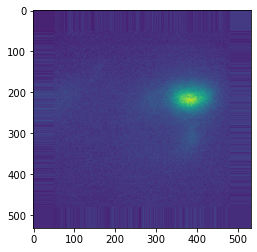

In [8]:
plt.figure(1)
plt.imshow(np.reshape(im_ev, (Nz, Nx, Ny), order='C')[7,:,:])
mempool = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()
print(mempool.used_bytes())
print(mempool.total_bytes())
print(pinned_mempool.n_free_blocks())
dev0 = cupy.cuda.Device(0)


print(dev0.mem_info[0])

size_of_files = obs.size + im_ev.size + otf.size + im_mask.size
print(obs.shape)
print(im_ev.shape)
print(otf.shape)
print(im_mask.shape)
print(size_of_files)
print(math.floor(dev0.mem_info[0]/size_of_files))
obs_cp = cupy.asarray(obs)
im_ev_cp = cupy.asarray(im_ev)
otf_cp = cupy.asarray(otf)
im_mask_cp = cupy.asarray(im_mask)
print(dev0.mem_info[0])
print(im_ev_cp.shape)


# plt.figure(2)
# plt.imshow(im_mask[:,:,:])


In [9]:
import RL_TV
for i in range(outer_iter):
    with cupy.cuda.Device(0):
        est = RL_TV.RL_TV(im_ev_cp, otf_cp, inner_iter, TV_reg, Nz, Ny, Nx)
        print('figure: ' + str(i))
        # plt.figure(i)
        # plt.imshow(np.real(est[19,:,:].get()))
        print(est.shape)
        # array = cupy.reshape(cupy.asnumpy(est),(532,532))
        # plt.imshow(array)
        im_ev_cp = np.real(cupy.fft.ifftn(cupy.fft.fftn(est)*otf_cp))
        im_ev_cp = cupy.maximum(im_ev_cp, 0) # maximum function =/= max function
        print('im_ev_cp.shape: ' + str(im_ev_cp.shape) + ' im_mask_cp.shape: ' + str(im_mask_cp.shape) + ' obs_cp.shape: ' + str(obs_cp.shape))
        #temp = np.reshape(im_ev_cp, (im_ev_cp.size,), order='C')
        #print('temp.shape: ' + str(temp.shape))
        #temp[im_mask_cp[:]] = obs_cp[:]
        #print('temp.shape after: ' + str(temp.shape))
        im_ev_cp[im_mask_cp[:]] = obs_cp[:]   

wI.size 11603984
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
J4[0].size: 2 J4[1].size: 2
type(J4): <class 'numpy.ndarray'>
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
J4[0].size: 2 J4[1].size: 2
type(J4): <class 'numpy.ndarray'>
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
J4[0].size: 2 J4[1].size: 2
type(J4): <class 'numpy.ndarray'>
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
J4[0].size: 2 J4[1].size: 2
type(J4): <class 'numpy.ndarray'>
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
J4[0].size: 2 J4[1].size: 2
type(J4): <class 'numpy.ndarray'>
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
J4[0].size: 2 J4[1].size: 2
type(J4): <class 'numpy.ndarray'>
Y.size: 11603984 Y.shape: (11603984,)
J2.shape: (11603984,)
J4[0].size: 2 J4[1].size: 2
type(J4): <class 'numpy.ndarray'>
Y.size: 1

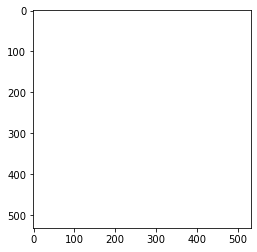

In [10]:
plt.imshow(np.reshape(est, (Nz, Ny, Nx), order='C')[0,:,:].get())

In [11]:
est

array([nan, nan, nan, ..., nan, nan, nan])

In [12]:
plt.imshow(np.real(im_ev_cp[21,49:481,49:481].get()))
plt.figure(2)
plt.imshow(stack[300,13,:,:])
EVdeconv = est[(z_pad+1):(z_pad+ZZ),(xy_pad+1):(xy_pad+XX), (xy_pad+1):(xy_pad+YY)] #% deconvolution results
maxEV = np.max(np.real(EVdeconv[:]))
print(maxEV)
EVdeconv = (np.real(EVdeconv)/maxEV) * (2^16 - 1)
plt.figure(3)
plt.imshow(np.real(EVdeconv[13,:,:].get()))

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
import pandas as pd
print(psf.shape)
print(psf)

#plibt = np.uint16((psf/np.max(psf))*(2**16 - 1))
#print(plibt.shape)
tiffile.imwrite("psfdouble.tif", psf)

(41, 532, 532)
[[[4.98883395e-37 6.51846442e-37 8.50850508e-37 ... 8.50850508e-37
   6.51846442e-37 4.98883395e-37]
  [6.51846442e-37 8.51709615e-37 1.11173048e-36 ... 1.11173048e-36
   8.51709615e-37 6.51846442e-37]
  [8.50850508e-37 1.11173048e-36 1.45113386e-36 ... 1.45113386e-36
   1.11173048e-36 8.50850508e-37]
  ...
  [8.50850508e-37 1.11173048e-36 1.45113386e-36 ... 1.45113386e-36
   1.11173048e-36 8.50850508e-37]
  [6.51846442e-37 8.51709615e-37 1.11173048e-36 ... 1.11173048e-36
   8.51709615e-37 6.51846442e-37]
  [4.98883395e-37 6.51846442e-37 8.50850508e-37 ... 8.50850508e-37
   6.51846442e-37 4.98883395e-37]]

 [[2.54021536e-40 3.41636620e-40 4.58957699e-40 ... 4.58957699e-40
   3.41636620e-40 2.54021536e-40]
  [3.41636620e-40 4.59471202e-40 6.17257733e-40 ... 6.17257733e-40
   4.59471202e-40 3.41636620e-40]
  [4.58957699e-40 6.17257733e-40 8.29229573e-40 ... 8.29229573e-40
   6.17257733e-40 4.58957699e-40]
  ...
  [4.58957699e-40 6.17257733e-40 8.29229573e-40 ... 8.29229573